Question 1.1

In [34]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col
import matplotlib.pyplot as plt
import pandas as pd

# Start or get the existing Spark session
spark = SparkSession.builder.appName("DataWrangling").getOrCreate()

# Set the display options to show more characters in each column and not truncate the output
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)

# Load the data
df = spark.read.csv('transactionrecord.csv', header=True, inferSchema=True)

# 1.1.1 Replace 'NA' with '-1' in CustomerNo column
df = df.withColumn("CustomerNo", regexp_replace("CustomerNo", "NA", "-1"))

# 1.1.2 Remove non-alphabet characters from productName and save to a new column
df = df.withColumn("productName_process", regexp_replace("productName", "[^a-zA-Z ]", ""))

# 1.1.2 Show the first 5 rows of the modified DataFrame
df.select("CustomerNo", "productName", "productName_process").show(5, truncate=False)


+----------+-----------------------------------+-----------------------------------+
|CustomerNo|productName                        |productName_process                |
+----------+-----------------------------------+-----------------------------------+
|17490     |Set Of 2 Wooden Market Crates      |Set Of  Wooden Market Crates       |
|13069     |Christmas Star Wish List Chalkboard|Christmas Star Wish List Chalkboard|
|13069     |Storage Tin Vintage Leaf           |Storage Tin Vintage Leaf           |
|13069     |Tree T-Light Holder Willie Winkie  |Tree TLight Holder Willie Winkie   |
|13069     |Set Of 4 Knick Knack Tins Poppies  |Set Of  Knick Knack Tins Poppies   |
+----------+-----------------------------------+-----------------------------------+
only showing top 5 rows



Question 1.2

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+------------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country| productName_process|           Revenue|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+--------------------+------------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|Set Of  Wooden Ma...|            257.64|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|Christmas Star Wi...|383.40000000000003|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|Storage Tin Vinta...|138.35999999999999|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0

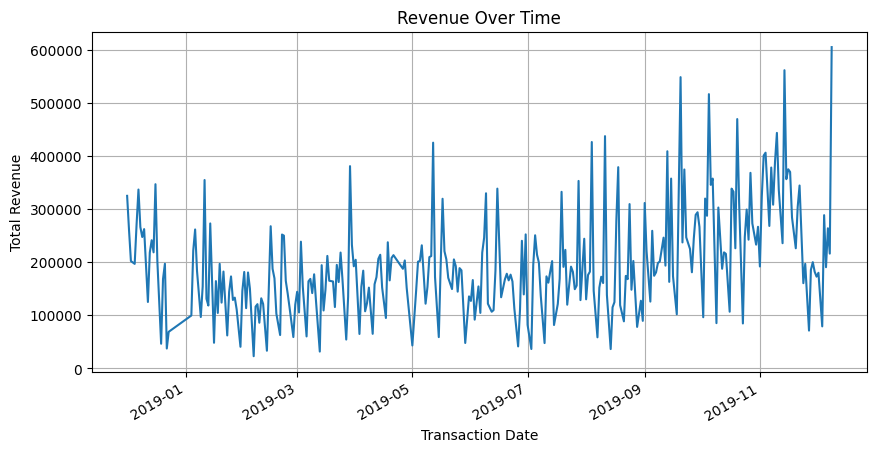

In [35]:
# Question 1.2.1: Calculate revenue by multiplying 'price' and 'Quantity', ensuring the result is a float.
# Display the top 5 rows to verify the calculations.
df = df.withColumn("Revenue", col("price") * col("Quantity").cast("float"))
df.show(5)

# Question 1.2.2: Convert Spark DataFrame to a pandas DataFrame for advanced processing.
# Create a new 'transaction_date' column from 'Date', converted to the datetime format for better handling.
pandas_df = df.select("Date", "Revenue").toPandas()
pandas_df['transaction_date'] = pd.to_datetime(pandas_df['Date'])
print(pandas_df.head())

# Question 1.2.3: Plot the total revenue over time using a line plot to identify trends and insights.
# This visual representation helps analyze how revenue varies with transaction dates.
plt.figure(figsize=(10, 5))
pandas_df.groupby('transaction_date')['Revenue'].sum().plot(kind='line', title='Revenue Over Time')
plt.xlabel('Transaction Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

The revenue shows significant volatility over time with noticeable peaks and troughs. This could indicate variability in sales due to factors like seasonal demand, promotions, or changes in consumer behavior

The sharp peaks suggest that there are specific days or periods with exceptionally high sales. Identifying these can help in planning better inventory and marketing strategies.

The valleys, especially those that dip significantly, might indicate periods of low activity where consumer engagement could be improved. Analyzing what contributes to these dips—be it inventory issues, lesser marketing efforts, or external economic factors—could provide actionable insights.

A moving average or trend line overlaid on this plot could help in understanding the underlying trend beyond the weekly or monthly fluctuations. This can be particularly useful for strategic planning and forecasting.

Question 1.3

In [36]:
from pyspark.sql.functions import dayofweek, date_format

# Ensure 'Date' is in date format to facilitate extraction of day of the week.
df = df.withColumn("Date", df["Date"].cast("date"))

# Add a 'DayOfWeek' column to capture the day of the week as an integer (Sunday=1, Saturday=7), facilitating aggregation based on days of the week.
df = df.withColumn("DayOfWeek", dayofweek(df["Date"]))

# Question 1.3.1: Calculate the average revenue per day of the week. Display the day with the highest average revenue to identify which weekday typically sees the highest sales.
avg_revenue_by_day = df.groupBy("DayOfWeek").avg("Revenue").orderBy("avg(Revenue)", ascending=False)
avg_revenue_by_day.show(1)  # Displays the day with the highest average revenue.

# Capture the weekday with the highest average revenue to focus subsequent analyses on this day.
that_workday = avg_revenue_by_day.first()["DayOfWeek"]

# Question 1.3.2: Identify the top-selling product by revenue on 'that_workday', providing insight into product preferences on high sales days.
top_products_revenue = df.filter(df["DayOfWeek"] == that_workday).groupBy("productName_process").sum("Revenue").orderBy("sum(Revenue)", ascending=False)
top_products_revenue.show(1)  # Shows the top revenue product for 'that_workday'.

# Also, identify the top-selling product by quantity on 'that_workday' to understand volume versus revenue dynamics.
top_products_quantity = df.filter(df["DayOfWeek"] == that_workday).groupBy("productName_process").sum("Quantity").orderBy("sum(Quantity)", ascending=False)
top_products_quantity.show(1)  # Shows the top product by quantity for 'that_workday'.

# Question 1.3.3: Display the top 5 products by overall revenue and quantity to see which products consistently perform well across all days, indicating steady consumer demand.
top_5_revenue_all_time = df.groupBy("productName_process").sum("Revenue").orderBy("sum(Revenue)", ascending=False)
top_5_quantity_all_time = df.groupBy("productName_process").sum("Quantity").orderBy("sum(Quantity)", ascending=False)
top_5_revenue_all_time.show(5)  # Shows the top 5 products by total revenue.
top_5_quantity_all_time.show(5)  # Shows the top 5 products by total quantity.


+---------+------------------+
|DayOfWeek|      avg(Revenue)|
+---------+------------------+
|     NULL|112.38934326466476|
+---------+------------------+

+-------------------+------------+
|productName_process|sum(Revenue)|
+-------------------+------------+
+-------------------+------------+

+-------------------+-------------+
|productName_process|sum(Quantity)|
+-------------------+-------------+
+-------------------+-------------+

+--------------------+------------------+
| productName_process|      sum(Revenue)|
+--------------------+------------------+
|      Popcorn Holder|         583286.51|
|World War  Glider...|         557170.43|
|Paper Craft Littl...|501359.05000000005|
|Cream Hanging Hea...| 451401.7000000003|
|Assorted Colour B...|420743.69999999966|
+--------------------+------------------+
only showing top 5 rows

+--------------------+-------------+
| productName_process|sum(Quantity)|
+--------------------+-------------+
|      Popcorn Holder|        56450|
|World 

Question 1.4

In [37]:
from pyspark.sql.functions import month

# Assuming 'Country' and 'Date' are columns in your DataFrame and 'Date' is already in a date format.

# Question 1.4.1: Aggregate revenue by country to identify which country generates the highest revenue.
revenue_by_country = df.groupBy("Country").sum("Revenue").withColumnRenamed("sum(Revenue)", "TotalRevenue")
top_country = revenue_by_country.orderBy("TotalRevenue", ascending=False).first()

# Display the results: Show which country has the highest revenue.
print(f"Country with the highest revenue: {top_country['Country']} with total revenue: {top_country['TotalRevenue']}")

# Question 1.4.2 : Filter data for the country with the highest revenue and aggregate revenue by month.
df_top_country = df.filter(df["Country"] == top_country["Country"])
revenue_by_month = df_top_country.groupBy(month("Date").alias("Month")).sum("Revenue").withColumnRenamed("sum(Revenue)", "MonthlyRevenue")

# Identify which month had the highest revenue within that country.
top_month = revenue_by_month.orderBy("MonthlyRevenue", ascending=False).first()

# Display the results: Show which month within that country had the highest revenue.
print(f"In {top_country['Country']}, the month with the highest revenue is: Month {top_month['Month']} with revenue: {top_month['MonthlyRevenue']}")


Country with the highest revenue: United Kingdom with total revenue: 49994030.17000068
In United Kingdom, the month with the highest revenue is: Month None with revenue: 49994030.17000068


Question 1.5

In [38]:
from pyspark.sql.functions import countDistinct

# Question 1.5.1: Determine which customer shops most frequently by counting unique transaction numbers per customer.'transactionNo' is used as a unique identifier for each shopping trip, ensuring accurate frequency measurement.
customer_frequency = df.groupBy("CustomerNo").agg(countDistinct("transactionNo").alias("ShoppingTrips"))
most_frequent_customer = customer_frequency.orderBy("ShoppingTrips", ascending=False).first()

# Output the results, identifying the customer who has the highest number of shopping trips.
print(f"Most frequent shopper: CustomerNo {most_frequent_customer['CustomerNo']} with {most_frequent_customer['ShoppingTrips']} shopping trips.")

# Question 1.5.2: Analyze the buying preferences of the most frequent shopper by examining the products they purchase most. Transactions are filtered to only include those where 'Quantity' is positive, indicating a purchase was made.
product_preferences = df.filter((df["CustomerNo"] == most_frequent_customer["CustomerNo"]) & (df["Quantity"] > 0))
top_products = product_preferences.groupBy("productName_process").sum("Quantity").orderBy("sum(Quantity)", ascending=False)

# Display the top 5 products purchased by the most frequent shopper, revealing their preferences.
print("Top products purchased by the most frequent shopper:")
top_products.show(5)  # Shows the top 5 most purchased products


Most frequent shopper: CustomerNo 14911 with 241 shopping trips.
Top products purchased by the most frequent shopper:
+--------------------+-------------+
| productName_process|sum(Quantity)|
+--------------------+-------------+
| Cake Cases Vinta...|         1440|
|Set Of  Vintage C...|         1140|
| Doilies Vintage ...|         1068|
|      Popcorn Holder|          928|
|  Vintage Snap Cards|          804|
+--------------------+-------------+
only showing top 5 rows

